In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression

In [5]:
df = pd.read_csv("data/full_wudc_data.csv")

In [11]:
positions = ["og", "oo", "cg", "co"]
for team, speakers in zip(
    positions,
    [["pm", "dpm"], ["lo", "dlo"], ["gm", "gw"], ["om", "ow"]]
):
    df[f"{team}_speaks"] = df[f"{speakers[0]}_score"] + df[f"{speakers[1]}_score"]


In [13]:
temp_dfs = []
for i in range(4):
    for j in range(i + 1, 4):
        team_a, team_b = positions[i], positions[j]
        temp_df = pd.DataFrame({
            "team_a": team_a,
            "team_b": team_b,
            "team_a_id": df[team_a],
            "team_b_id": df[team_b],
            "year": df["year"],
            "round": df["round"],
            "a_wins": df[f"{team_a}_speaks"] > df[f"{team_b}_speaks"]
        })
        temp_dfs.append(temp_df)
split_df = pd.concat(temp_dfs, ignore_index=True)

In [ ]:
def get_preds_for_logreg(df):
    teams = list(set(df["team_a_id"]) | set(df["team_b_id"]))
    roundposes = list(set(df["a_roundpos"]) | set(df["b_roundpos"]))
    preds = pd.DataFrame(0, index=df.index, columns=teams + roundposes)
    preds = preds.add(pd.get_dummies(df["team_a_id"]).astype(int), fill_value=0)
    preds = preds.sub(pd.get_dummies(df["team_b_id"]), fill_value=0)
    preds = preds.add(pd.get_dummies(df["a_roundpos"]), fill_value=0)
    preds = preds.sub(pd.get_dummies(df["b_roundpos"]), fill_value=0)
    preds.columns = [str(i) for i in preds.columns]
    return preds

In [97]:
total_records = {}

for c_val in np.logspace(-0.5, 2, 25):
    c_records = {}
    
    for year in split_df["year"].unique():
        year_vals = {}
    
        # Set up dataframe and targets and whatever
        year_df = split_df[split_df["year"] == year].copy()
        year_df["a_roundpos"] = year_df["round"].astype(str) + year_df["team_a"]
        year_df["b_roundpos"] = year_df["round"].astype(str) + year_df["team_b"]
        preds = get_preds_for_logreg(year_df)
        targ = year_df["a_wins"]
    
        # Get motion biases, I know this is a bit acausal but it should be fine
        model = LogisticRegression(fit_intercept=False, C=c_val)
        model.fit(preds, targ)
        betas = pd.Series(model.coef_[0], index=preds.columns)
        year_df["a_bias"] = year_df["a_roundpos"].map(betas)
        year_df["b_bias"] = year_df["b_roundpos"].map(betas)
    
        # Get geomean prob for each round
        for round_num in range(1, 10):
            round_df = year_df[year_df["round"] == round_num].copy()
    
            # Get skill estimates for teams by looking at other eight rounds, fill nans with 0
            year_df_minus_round = year_df[year_df["round"] != round_num]
            round_preds = get_preds_for_logreg(year_df_minus_round)
            target = year_df_minus_round["a_wins"]
            model = LogisticRegression(fit_intercept=False, C=c_val)
            model.fit(round_preds, target)
            betas = pd.Series(model.coef_[0], index=round_preds.columns)
            round_df["a_skill"] = round_df["team_a_id"].astype(str).map(betas).fillna(0)
            round_df["b_skill"] = round_df["team_b_id"].astype(str).map(betas).fillna(0)
    
            # Evaluate the fit
            logit = round_df["a_bias"] + round_df["a_skill"] - round_df["b_bias"] - round_df["b_skill"]
            round_df["prob_a_wins"] = 1 / (1 + np.exp(-logit))
            round_df["log_prob_actual"] = np.log(np.where(round_df["a_wins"], round_df["prob_a_wins"], 1 - round_df["prob_a_wins"]))
            year_vals[round_num] = np.exp(round_df["log_prob_actual"].mean())
    
        c_records[year] = year_vals
        print(f"Finished {year}\r", end="")

    total_records[c_val] = c_records
    print(f"Finished C={c_val:.3f}")

Finished C=0.316
Finished C=0.402
Finished C=0.511
Finished C=0.649
Finished C=0.825
Finished C=1.049
Finished C=1.334
Finished C=1.695
Finished C=2.154
Finished C=2.738
Finished C=3.481
Finished C=4.424
Finished C=5.623
Finished C=7.148
Finished C=9.085
Finished C=11.548
Finished C=14.678
Finished C=18.657
Finished C=23.714
Finished C=30.142
Finished C=38.312
Finished C=48.697
Finished C=61.897
Finished C=78.674
Finished C=100.000


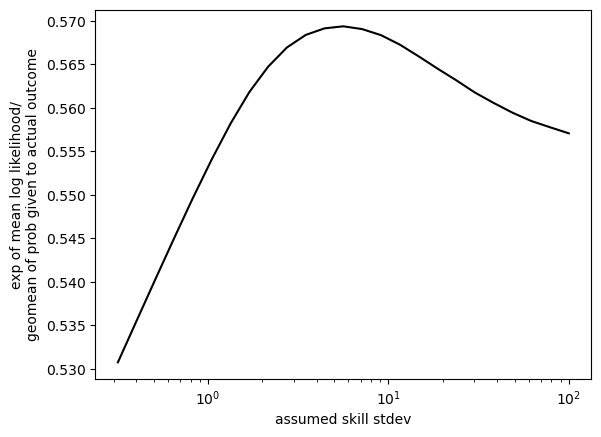

In [121]:
fig, ax = plt.subplots()
scores = pd.Series(
    [np.exp(np.log(pd.DataFrame(total_records[C])).mean().mean()) for C in total_records],
    index=[C for C in total_records]
)
ax.plot(scores.index, scores, color="black")
ax.set_xlabel("assumed skill stdev")
ax.set_ylabel("exp of mean log likelihood/\ngeomean of prob given to actual outcome")
ax.set_xscale("log")
plt.show()

In [123]:
scores[abs(scores.index - 5) < 3]

2.154435    0.564711
2.738420    0.566918
3.480701    0.568358
4.424186    0.569110
5.623413    0.569342
7.147706    0.569025
dtype: float64

Looks like it tops out at about 5 or 6, but it's flat enough there that we don't really care too much. 